In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import iglob
from scipy.spatial.distance import cityblock, cosine

from machine_learning.decomposition import PCA, ICA, LDA
from machine_learning.neighbours import kNN

import sklearn.decomposition
import sklearn.discriminant_analysis

In [2]:
def center(X):
    return X - np.mean(X, axis=0)

In [3]:
def standardize(X):
    return X / np.std(X, axis=0)

In [4]:
def preprocess(X):
    X = center(X)
    return standardize(X)

In [5]:
# Faster than SciPy's Manhattan
def euclidean(a, b):
    return np.linalg.norm(a - b)

In [6]:
# Read image files
def read_images(directory_name):
    X = []; y = []; rc = [] # y : image label, yr : racial category
    for image in iglob("data/" + directory_name + "/*.pgm"):
        face = cv2.resize(plt.imread(image), (50, 60)).flatten()
        X = np.append(X, face)
        y = np.append(y, image.split("/")[2][:5]) # Select the substring in the name that contains the class
        rc = np.append(rc, image.split("/")[2][-5:-4])
    X = np.reshape(X, (-1, 3000))
    return X, y, rc

In [7]:
def results(rank, knn_, X, y):
    true = 0; total = len(X)
    for i in range(total):
        if y[i] in knn_.find_knn(rank, X[i]):
            true += 1
    return round(true / total*100, 2)

# Training

In [8]:
X, y, _ = read_images("fa_training_set")
X = preprocess(X)
Xt = preprocess(np.transpose(X)) # input data for ICA1

In [9]:
# PCA
pca = PCA(n_components=180) # 40% of the number of images
pca.fit(X)
print("The cumulative variance of the first 180 components is " + str(round(pca.explained_variance, 2)) + "%")

The cumulative variance of the first 180 components is 99.69%


In [10]:
# ICA1
pcat = PCA(n_components=180)
pcat.fit(Xt)
ica1 = ICA(n_components=180, method="deflationary")
ica1.fit(np.dot(Xt, pcat.components))

In [11]:
# ICA2
ica2 = ICA(n_components=180, method="deflationary")
ica2.fit(np.dot(X, pca.components))

In [34]:
# LDA
lda = LDA(n_components=180) 
lda.fit(np.dot(X, pca.components), y)

In [13]:
%timeit pca.fit(X)
%timeit sklearn.decomposition.PCA(n_components=192).fit(X)

160 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
186 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
%timeit ica2.fit(np.dot(X, pca.components))
%timeit sklearn.decomposition.FastICA(n_components=180).fit(np.dot(X, pca.components))

2.9 s ± 327 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
966 ms ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit lda.fit(np.dot(X, pca.components), y)
%timeit sklearn.discriminant_analysis.LinearDiscriminantAnalysis(n_components=180).fit(np.dot(X, pca.components), y)

60.6 ms ± 4.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.6 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
PC = pca.components
IC1 = np.dot(ica1.components, np.transpose(PC))
IC2 = np.dot(ica2.components, np.transpose(PC))
LD = np.dot(lda.components, np.transpose(PC))

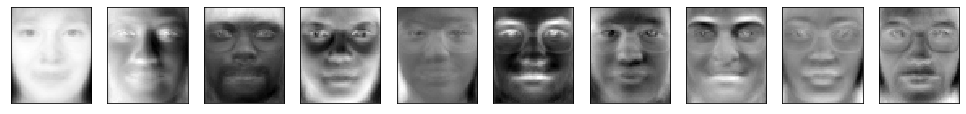

In [36]:
PC_ = np.transpose(PC) # for vizualization
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(PC_[i].reshape(60, 50), cmap="gray")

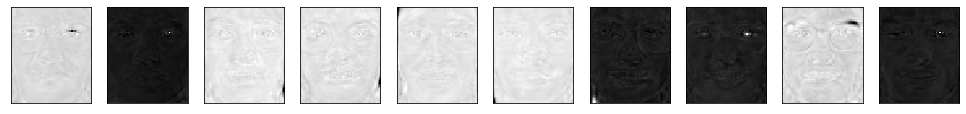

In [37]:
IC1_ = np.dot(ica1.components, np.dot(np.transpose(pcat.components), X)) # for vizualization
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC1_[i].reshape(60, 50), cmap="gray")

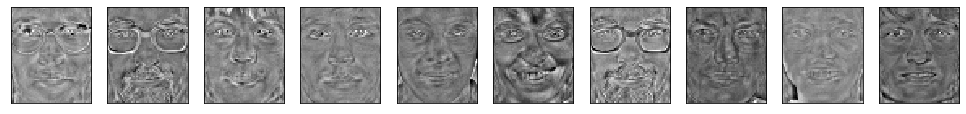

In [38]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC2[i].reshape(60, 50), cmap="gray")

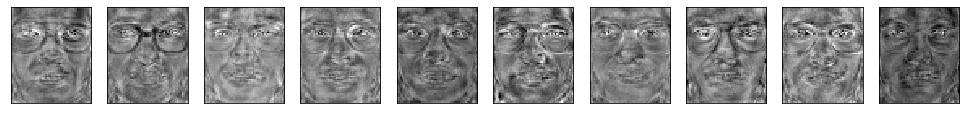

In [39]:
fig, axes = plt.subplots(1, 10, figsize=(17, 3), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(LD[i].reshape(60, 50), cmap="gray")

# Results

In [40]:
Xg, yg, rcg = read_images("fa_gallery_set")
Xg = preprocess(Xg)
Xg_pca = np.dot(Xg, PC)
Xg_ica1 = np.dot(Xg, np.transpose(IC1))
Xg_ica2 = np.dot(Xg, np.transpose(IC2))
Xg_lda = np.dot(Xg, np.transpose(LD))

In [41]:
Xp, yp, rcp = read_images("fa_probe_set")
Xp = preprocess(Xp)
Xp_pca = np.dot(Xp, PC)
Xp_ica1 = np.dot(Xp, np.transpose(IC1))
Xp_ica2 = np.dot(Xp, np.transpose(IC2))
Xp_lda = np.dot(Xp, np.transpose(LD))

## Individual image recognition

In [42]:
pca_l1 = kNN(Xg_pca, yg, cityblock, 100)
print("PCA+L1: " + str(results(1, pca_l1, Xp_pca, yp)))
pca_l2 = kNN(Xg_pca, yg, euclidean, 100)
print("PCA+L2: " + str(results(1, pca_l2, Xp_pca, yp)))
pca_cos = kNN(Xg_pca, yg, cosine, 100)
print("PCA+COS: " + str(results(1, pca_cos, Xp_pca, yp)))

PCA+L1: 78.67
PCA+L2: 76.0
PCA+COS: 77.33


In [43]:
ica1_l1 = kNN(Xg_ica1, yg, cityblock, 100)
print("ICA1+L1: " + str(results(1, ica1_l1, Xp_ica1, yp)))
ica1_l2 = kNN(Xg_ica1, yg, euclidean, 100)
print("ICA1+L2: " + str(results(1, ica1_l2, Xp_ica1, yp)))
ica1_cos = kNN(Xg_ica1, yg, cosine, 100)
print("ICA1+COS: " + str(results(1, ica1_cos, Xp_ica1, yp)))

ICA1+L1: 72.0
ICA1+L2: 70.0
ICA1+COS: 82.0


In [44]:
ica2_l1 = kNN(Xg_ica2, yg, cityblock, 100)
print("ICA2+L1: " + str(results(1, ica2_l1, Xp_ica2, yp)))
ica2_l2 = kNN(Xg_ica2, yg, euclidean, 100)
print("ICA2+L2: " + str(results(1, ica2_l2, Xp_ica2, yp)))
ica2_cos = kNN(Xg_ica2, yg, cosine, 100)
print("ICA2+COS: " + str(results(1, ica2_cos, Xp_ica2, yp)))

ICA2+L1: 71.33
ICA2+L2: 69.33
ICA2+COS: 82.0


In [45]:
lda_l1 = kNN(Xg_lda, yg, cityblock, 100)
print("LCA+L1: " + str(results(1, lda_l1, Xp_lda, yp)))
lda_l2 = kNN(Xg_lda, yg, euclidean, 100)
print("LCA+L2: " + str(results(1, lda_l2, Xp_lda, yp)))
lda_cos = kNN(Xg_lda, yg, cosine, 100)
print("LCA+COS: " + str(results(1, lda_cos, Xp_lda, yp)))

LCA+L1: 78.0
LCA+L2: 76.0
LCA+COS: 78.0


## Racial group recognition

In [46]:
pca_l1 = kNN(Xg_pca, rcg, cityblock, 100)
print("PCA+L1: " + str(results(1, pca_l1, Xp_pca, rcp)))
pca_l2 = kNN(Xg_pca, rcg, euclidean, 100)
print("PCA+L2: " + str(results(1, pca_l2, Xp_pca, rcp)))
pca_cos = kNN(Xg_pca, rcg, cosine, 100)
print("PCA+COS: " + str(results(1, pca_cos, Xp_pca, rcp)))

PCA+L1: 95.33
PCA+L2: 96.0
PCA+COS: 93.33


In [47]:
ica1_l1 = kNN(Xg_ica1, rcg, cityblock, 100)
print("ICA1+L1: " + str(results(1, ica1_l1, Xp_ica1, rcp)))
ica1_l2 = kNN(Xg_ica1, rcg, euclidean, 100)
print("ICA1+L2: " + str(results(1, ica1_l2, Xp_ica1, rcp)))
ica1_cos = kNN(Xg_ica1, rcg, cosine, 100)
print("ICA1+COS: " + str(results(1, ica1_cos, Xp_ica1, rcp)))

ICA1+L1: 85.33
ICA1+L2: 85.33
ICA1+COS: 96.67


In [48]:
ica2_l1 = kNN(Xg_ica2, rcg, cityblock, 100)
print("ICA2+L1: " + str(results(1, ica2_l1, Xp_ica2, rcp)))
ica2_l2 = kNN(Xg_ica2, rcg, euclidean, 100)
print("ICA2+L2: " + str(results(1, ica2_l2, Xp_ica2, rcp)))
ica2_cos = kNN(Xg_ica2, rcg, cosine, 100)
print("ICA2+COS: " + str(results(1, ica2_cos, Xp_ica2, rcp)))

ICA2+L1: 87.33
ICA2+L2: 85.33
ICA2+COS: 96.67


In [49]:
lda_l1 = kNN(Xg_lda, rcg, cityblock, 100)
print("LCA+L1: " + str(results(1, lda_l1, Xp_lda, rcp)))
lda_l2 = kNN(Xg_lda, rcg, euclidean, 100)
print("LCA+L2: " + str(results(1, lda_l2, Xp_lda, rcp)))
lda_cos = kNN(Xg_lda, rcg, cosine, 100)
print("LCA+COS: " + str(results(1, lda_cos, Xp_lda, rcp)))

LCA+L1: 96.67
LCA+L2: 96.0
LCA+COS: 94.0
